# QUESTION 1.2

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy

### K-means

In [6]:
def kmeans(dataset,iterations):
    min_loss = None
    final_dataframe = None
    for iter in range(iterations):
        first_run = True
        while True:
            if first_run == True:
                k = 3
                centers = {}
                for i in range(k):
                    centers[i+1] = (random.uniform(min(dataset["x1"]), max(dataset["x1"])), random.uniform(min(dataset["x2"]), max(dataset["x2"])))    
                for i, row in dataset.iterrows():
                    dataset.loc[i,"cluster"] = None # assign None to first run
                first_run = False
            
            # Assign points to cluster
            no_change = True
            for i, row in dataset.iterrows():
                x1 = row["x1"]
                x2 = row["x2"]
                dist = {}
                for j in centers:  # calculate distance to each centroid
                    x1c = centers[j][0]
                    x2c = centers[j][1]
                    dist[j] = ((x1-x1c)**2 + (x2-x2c)**2)**(0.5)
                min_c = min(dist, key=dist.get)
                if dataset.loc[i,"cluster"] != min_c:
                    no_change = False
                    dataset.loc[i,"cluster"] = min_c
            
            # Recalculate centroid
            grouped_data = dataset.groupby('cluster')
            for name, group in grouped_data:
                centers[name] = (np.mean(group["x1"]),np.mean(group["x2"]))
            
            # Calculate loss
            loss = 0
            for name, group in grouped_data:
                for i, row in group.iterrows():
                    x1 = row["x1"]
                    x2 = row["x2"]
                    x1c = centers[name][0]
                    x2c = centers[name][1]
                    square_distance = ((x1-x1c)**2 + (x2-x2c)**2)
                    loss += square_distance
        
            # Check convergence:
            if no_change == True:
                break
        #print(loss)
        if min_loss == None or loss < min_loss:
            min_loss = loss
            final_dataframe = copy.copy(dataset)
            
    return final_dataframe, min_loss

### GMM

In [153]:
import numpy as np
from scipy.stats import multivariate_normal

def multivariate_normal_pdf(x, mean, cov):
    mvn = multivariate_normal(mean=mean, cov=cov)
    return mvn.pdf(x)

def initialize_clusters(dataset, k):
    centers = {}
    for i in range(k):
        selected_columns = ['x1', 'x2']
        points_df = dataset[selected_columns]
        random_samples = points_df.sample(n=50, replace=True)
        random_mean_vector = random_samples.mean().values
        random_covariance_matrix = np.cov(random_samples.T) + 1e-6 * np.identity(2)  # Add small regularization term
        centers[i+1] = (random_mean_vector, random_covariance_matrix)
    return centers

def gmm(dataset, iterations):
    min_loss = None
    final_dataframe = None
    final_acc = None
    
    for iter in range(iterations):
        centers = initialize_clusters(dataset[['x1', 'x2']], k=3)
        prev_likelihood = 0
        
        count = 1
        while True:
            likelihood = 0
            
            # Expectation step: assign points to clusters
            for i, row in dataset.iterrows():
                x = np.array([row["x1"], row["x2"]])
                cluster_likelihoods = [multivariate_normal_pdf(x, centers[j][0], centers[j][1]) for j in centers]
                total_likelihood = np.sum(cluster_likelihoods)
                cluster_probabilities = np.array(cluster_likelihoods) / total_likelihood  # Normalize to obtain probabilities
                #print(cluster_probabilities, centers)
                cluster_assignment = np.random.choice(len(centers), p=cluster_probabilities)
                dataset.loc[i, "cluster"] = cluster_assignment + 1  # Cluster numbers are 1-indexed
                likelihood += np.log(total_likelihood)
            
            # Maximization step: update cluster parameters
            new_centers = {}
            for c in centers.keys():
                cluster_points = dataset[dataset["cluster"] == c][['x1', 'x2']]
                if len(cluster_points) > 0:
                    new_mean = cluster_points.mean().values
                    new_cov = np.cov(cluster_points.T) + 1e-6 * np.identity(2)  # Add small regularization term
                    new_centers[c] = (new_mean, new_cov)
            
            # Check convergence based on change in log-likelihood
            if count == 10000:
                break
                
            #get best accuracy
            acc = accuracy(dataset)
            #print(acc)
            if final_acc is None or acc > final_acc:
                final_acc = acc
                final_dataframe = dataset.copy()
                min_loss = likelihood
            
            centers = new_centers
            prev_likelihood = likelihood
            count +=1
            
#         if min_loss is None or likelihood < min_loss:
#             min_loss = likelihood
#             final_dataframe = dataset.copy()
            
    return final_dataframe, min_loss

### Accuracy

In [7]:
def accuracy(final_dataframe):
    # Calculate centers of Actual and Predict
    center_k = {}
    center_k2 = {}
    grouped_data = final_dataframe.groupby('cluster')
    for name, group in grouped_data:
        center_k2[name] = (np.mean(group["x1"]),np.mean(group["x2"]))
    grouped_data = final_dataframe.groupby("Distribution")
    for name, group in grouped_data:
        center_k[name] = (np.mean(group["x1"]),np.mean(group["x2"]))
    
    # Find the distance between all
    dist_all = {}
    for k2 in center_k2:
        dist_all[k2] = {}
        x1 = center_k2[k2][0]
        x2 = center_k2[k2][1]
        for k in center_k:
            x1c = center_k[k][0]
            x2c = center_k[k][1]
            d = ((x1-x1c)**2 + (x2-x2c)**2)**(0.5)
            dist_all[k2][k] = d
    
    # map based of the shortest distance
    cluster_mapping = {}
    mapped_k = []
    mapped_k2 = []
    while len(mapped_k) < len(center_k2):
        d_f = None
        k_f = None
        k_f2 = None
        for k2 in dist_all:
            if k2 in mapped_k2:
                continue
            for k in dist_all[k2]:
                if k in mapped_k:
                    continue
                d_aux = dist_all[k2][k]
                if d_f == None or d_aux<d_f:
                    d_f = copy.copy(d_aux)
                    k_f = copy.copy(k)
                    k_f2 = copy.copy(k2)
                #print(k2,k,d_aux,d_f,k_f,k_f2)
        cluster_mapping[k_f2] = k_f
        if k_f2 not in mapped_k2:
            mapped_k2.append(k_f2)
        if k_f not in mapped_k:
            mapped_k.append(k_f)
    
    # Calculate accuracy
    final_dataframe['cluster_map'] = final_dataframe['cluster'].map(cluster_mapping)
    count = 0
    for i, row in final_dataframe.iterrows():
        actual = row["Distribution"]
        pred = row["cluster_map"]
        if actual == pred:
            count +=1
        accuracy = count/len(final_dataframe)
    return accuracy

## Running

### Generate Data

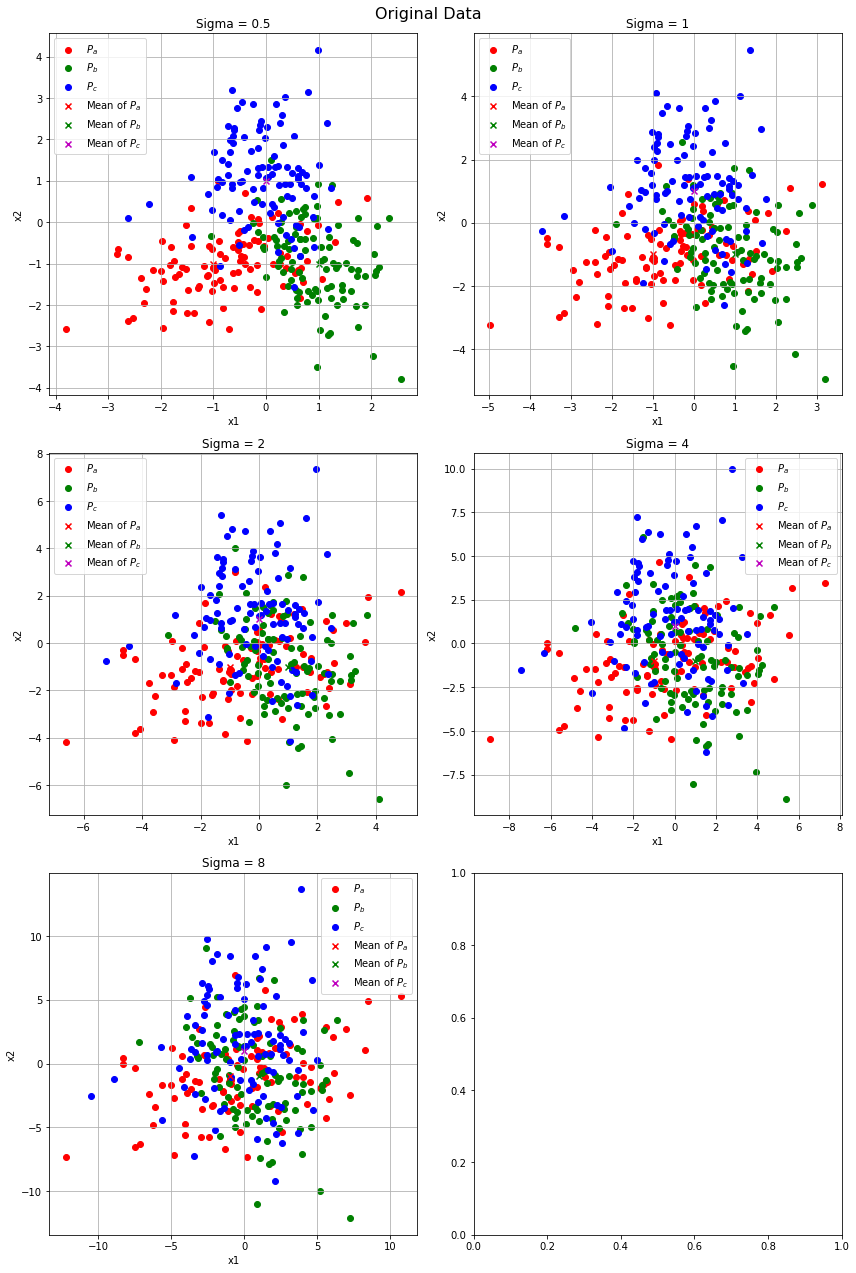

In [146]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
datasets = {}

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.suptitle('Original Data', fontsize=16)
# Loop through different standard deviations and populate subplots
for idx, sigma in enumerate([0.5, 1, 2, 4, 8]):
    np.random.seed(12)
    
    # Parameters
    num_points_per_distribution = 100
    
    # Mean vectors and covariance matrices for the three Gaussian distributions
    mean_a = np.array([-1, -1])
    cov_a = sigma * np.array([[2, 0.5], [0.5, 1]])
    
    mean_b = np.array([1, -1])
    cov_b = sigma * np.array([[1, -0.5], [-0.5, 2]])
    
    mean_c = np.array([0, 1])
    cov_c = sigma * np.array([[1, 0], [0, 2]])

    labels = ['A'] * num_points_per_distribution + ['B'] * num_points_per_distribution + ['C'] * num_points_per_distribution

    # Generate random samples from the three Gaussian distributions
    samples_a = np.random.multivariate_normal(mean_a, cov_a, num_points_per_distribution)
    samples_b = np.random.multivariate_normal(mean_b, cov_b, num_points_per_distribution)
    samples_c = np.random.multivariate_normal(mean_c, cov_c, num_points_per_distribution)
    
    data = np.vstack((samples_a, samples_b, samples_c))
    dataset = pd.DataFrame(data, columns=['x1', 'x2'])
    dataset['Distribution'] = labels
    
    datasets[sigma] = dataset

    # Plot the synthetic dataset in the corresponding subplot
    if idx < len(axes.flat):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
    
        ax.scatter(samples_a[:, 0], samples_a[:, 1], c='r', marker='o', label='$P_a$')
        ax.scatter(samples_b[:, 0], samples_b[:, 1], c='g', marker='o', label='$P_b$')
        ax.scatter(samples_c[:, 0], samples_c[:, 1], c='b', marker='o', label='$P_c$')
    
        ax.scatter(mean_a[0], mean_a[1], c='r', marker='x', label='Mean of $P_a$')
        ax.scatter(mean_b[0], mean_b[1], c='g', marker='x', label='Mean of $P_b$')
        ax.scatter(mean_c[0], mean_c[1], c='m', marker='x', label='Mean of $P_c$')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.legend()
        ax.set_title(f'Sigma = {sigma}')
        ax.grid(True)
    else:
        break
    
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('2_original.png')
plt.show()


### Run K-means

KMEANS 0.5 317.75217720204 0.78
KMEANS 1 538.0698147229078 0.6733333333333333
KMEANS 2 970.8611103700501 0.5933333333333334
KMEANS 4 1805.8634239181217 0.51
KMEANS 8 3490.924015695408 0.47


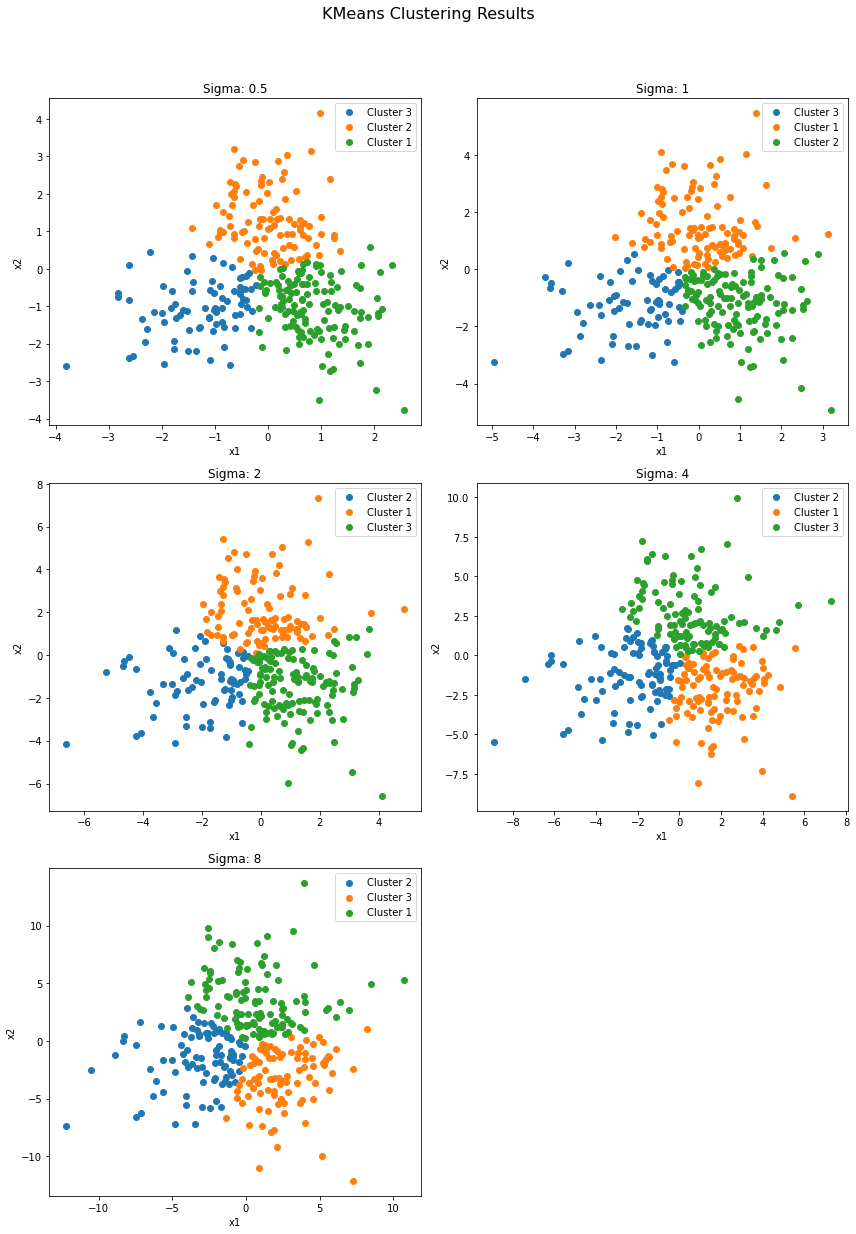

In [147]:
import matplotlib.pyplot as plt

results = {}

# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Add an overall title
fig.suptitle('KMeans Clustering Results', fontsize=16)

for index, ax in zip(datasets, axs.flat):
    results[index] = {}
    dataset = datasets[index]
    # kmeans
    final_dataframe, likelihood = kmeans(dataset, 1)
    acc = accuracy(final_dataframe)
    print("KMEANS", index, likelihood, acc)
    results[index]["KMEANS"] = (likelihood, acc)
    
    df = final_dataframe
    # Iterate through unique clusters and plot points with corresponding colors
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {int(cluster)}')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Sigma: ' + str(index))
    ax.legend()

# Hide any empty subplots
for ax in axs.flat[len(datasets):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the overall layout to accommodate the title
plt.savefig('2_kmeans.png')
plt.show()


### Run GMM

GMM 0.5 -584.370475744219 0.7866666666666666
GMM 1 -723.727000700059 0.69
GMM 2 -888.9202347271369 0.59
GMM 4 -1074.8899718874025 0.5533333333333333
GMM 8 -1273.092485661524 0.54


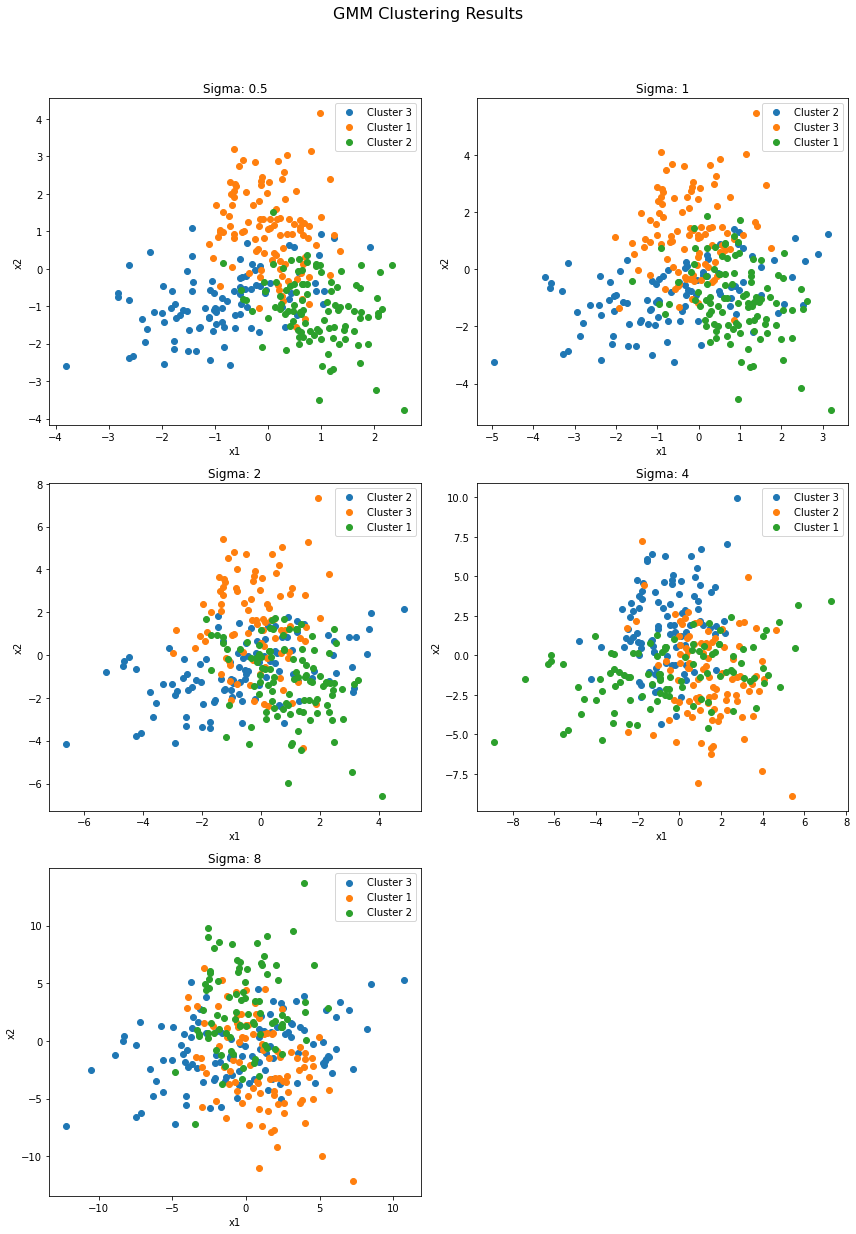

In [154]:
import matplotlib.pyplot as plt

results = {}

# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Add an overall title
fig.suptitle('GMM Clustering Results', fontsize=16)

for index, ax in zip(datasets, axs.flat):
    results[index] = {}
    dataset = datasets[index]
    # kmeans
    final_dataframe, likelihood = gmm(dataset, 1)
    acc = accuracy(final_dataframe)
    print("GMM", index, likelihood, acc)
    results[index]["GMM"] = (likelihood, acc)
    
    df = final_dataframe
    # Iterate through unique clusters and plot points with corresponding colors
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {int(cluster)}')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Sigma: ' + str(index))
    ax.legend()

# Hide any empty subplots
for ax in axs.flat[len(datasets):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the overall layout to accommodate the title
plt.savefig('2_gmm.png')
plt.show()

# QUESTION 2.3

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd

In [157]:
data_2D = pd.read_csv("data/data2D.csv", header=None).values
data_1000D = pd.read_csv("data/data1000D.csv", header=None).values

### Original data

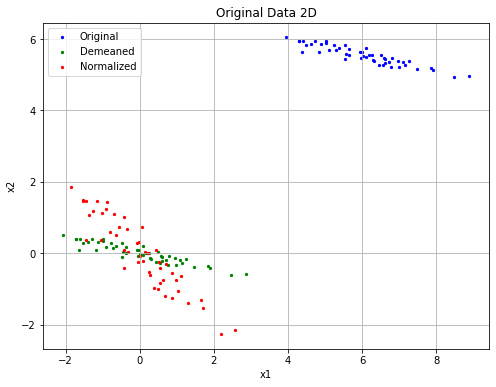

In [158]:
org_data = data_2D

# Demean the data
demeaned_data = org_data - np.mean(org_data, axis=0)

# Normalize the data
normalized_data = (org_data - np.mean(org_data, axis=0)) / np.std(org_data, axis=0)

# Create a scatter plot with different colors for each dataset
plt.figure(figsize=(8, 6))

# Plot original data in blue
plt.scatter(org_data[:, 0], org_data[:, 1], color='blue', marker='o', s=5, label='Original')

# Plot demeaned data in green
plt.scatter(demeaned_data[:, 0], demeaned_data[:, 1], color='green', marker='o', s=5, label='Demeaned')

# Plot normalized data in red
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], color='red', marker='o', s=5, label='Normalized')

plt.title('Original Data 2D')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.legend()
plt.savefig('pca_datas.png')
plt.show()

### Functions

In [173]:
def pca_buggy(org_data, d):
    data = org_data 
    cov = np.cov(data, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    indices = np.argsort(eig_val)[::-1][:d]  # Choose the top d eigenvectors
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:, indices]
    pca_data = np.dot(data, eig_vec)
    # Reconstruct the data and error
    recon_X = np.dot(pca_data, eig_vec.T)  # Add back the mean
    # Compute reconstruction loss
    loss = np.mean(np.square(recon_X - org_data))
    print("Reconstruction loss: ", loss)
    return pca_data, recon_X

def pca_demeaned(org_data, d):
    data = org_data - np.mean(org_data, axis=0)  # Center the data
    cov = np.cov(data, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    indices = np.argsort(eig_val)[::-1][:d]  # Choose the top d eigenvectors
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:, indices]
    pca_data = np.dot(data, eig_vec)
    # Reconstruct the data and error
    recon_X = np.dot(pca_data, eig_vec.T) + np.mean(org_data, axis=0)  # Add back the mean
    # Compute reconstruction loss
    loss = np.mean(np.square(recon_X - org_data))
    print("Reconstruction loss: ", loss)
    return pca_data, recon_X

def pca_normalized(org_data,d):
    data = (org_data - np.mean(org_data, axis=0)) / np.std(org_data, axis=0)
    cov = np.cov(data, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    indices = np.argsort(eig_val)[::-1][:d]  # Choose the top d eigenvectors
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:, indices]
    pca_data = np.dot(data, eig_vec)
    # Reconstruct the data and error
    recon_X = np.dot(pca_data,eig_vec.T)*np.std(org_data, axis=0) + np.mean(org_data, axis=0)
    # Compute reconstruction loss
    loss = np.mean(np.square(recon_X - org_data))
    print("Reconstruction loss: ", loss)
    return pca_data, recon_X

# def pca_dro(X, d):
#     # Compute mean and center the data
#     mean_X = np.mean(X, axis=0)
#     Y = X - mean_X
    
#     # Compute covariance matrix
#     cov_matrix = np.dot(Y.T, Y) / len(X)
    
#     # Perform SVD
#     U, Sigma, Vt = np.linalg.svd(cov_matrix)
    
#     # Truncate SVD to d dimensions
#     U_d = U[:, :d]
#     Sigma_d = np.diag(Sigma[:d])
#     Vt_d = Vt[:d, :]
    
#     # Compute A and Z
#     A = np.dot(U_d, np.sqrt(Sigma_d))
#     Z = np.dot(Y, Vt_d.T)
    
#     # Reconstruct data
#     X_hat = np.dot(Z, A.T) + mean_X
    
#     # Compute reconstruction error
#     reconstruction_error = np.linalg.norm(X - X_hat, ord='fro') / np.linalg.norm(X, ord='fro')
#     print("Reconstruction loss: ", reconstruction_error)
#     return reconstruction_error, X_hat

def pca_dro(X, d):
    # Compute mean and center the data
    mean_X = np.mean(X, axis=0)
    Y = X - mean_X
    
    # Compute covariance matrix
    cov_matrix = np.dot(Y.T, Y) / len(X)
    
    # Perform SVD
    U, Sigma, Vt = np.linalg.svd(cov_matrix)
    
    # Truncate SVD to d dimensions
    U_d = U[:, :d]
    
    # Compute projection matrix and transformed data
    projection_matrix = U_d
    X_d = np.dot(Y, projection_matrix)
    
    # Reconstruct data
    X_hat = np.dot(X_d, projection_matrix.T) + mean_X
    
    # Compute reconstruction error
    reconstruction_error = np.linalg.norm(X - X_hat, ord='fro') / np.linalg.norm(X, ord='fro')
    print("Reconstruction loss: ", reconstruction_error)
    return reconstruction_error, X_hat

def choose_d(org_data):
    demeaned_data = org_data - np.mean(org_data, axis=0)
    data = demeaned_data
    cov = np.cov(data.T)
    cov = np.round(cov, 2)
    eig_val, eig_vec = np.linalg.eig(cov)
    indices = np.arange(0,len(eig_val), 1)
    indices = ([x for _,x in sorted(zip(eig_val, indices))])[::-1]
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:,indices]
    sum_eig_val = np.sum(eig_val)
    explained_variance = eig_val/ sum_eig_val    
    return explained_variance

### 2D Data

In [174]:
org_data = data_2D
pca_data1, recon_X1 = pca_buggy(org_data,1)
pca_data2, recon_X2 = pca_demeaned(org_data,1)
pca_data3, recon_X3 = pca_normalized(org_data,1)
pca_data4, recon_X4 = pca_dro(org_data,1)

Reconstruction loss:  22.68257835609427
Reconstruction loss:  0.005003042814256452
Reconstruction loss:  0.024736041727385336
Reconstruction loss:  0.012102013050059514


### Plots 2D

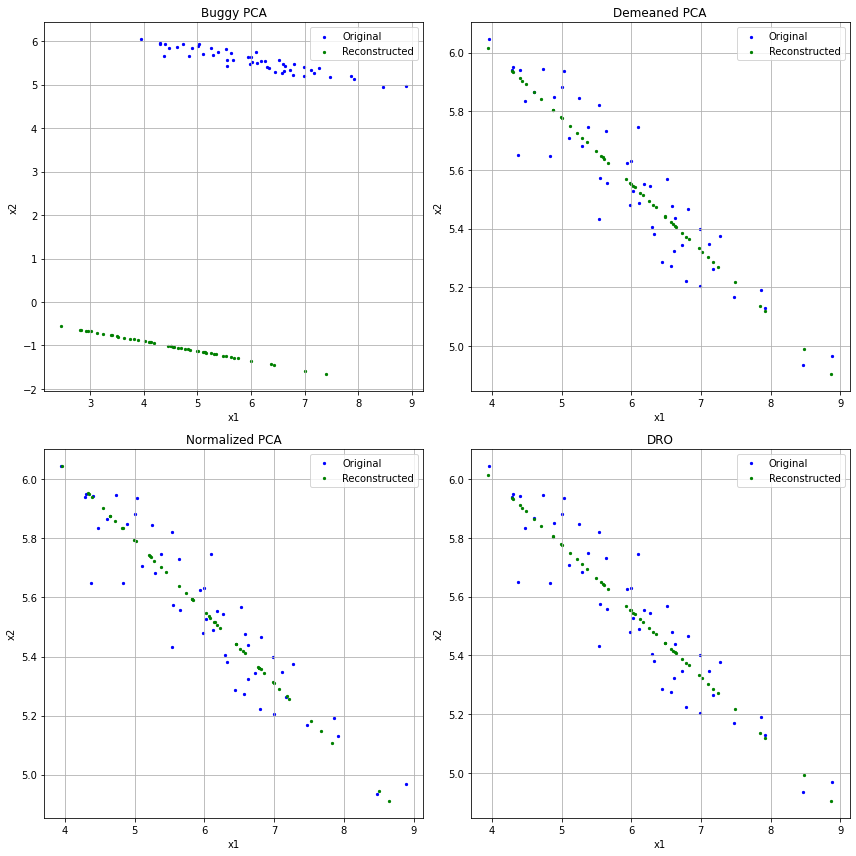

In [175]:
# Create subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Buggy PCA
axs[0, 0].scatter(org_data[:, 0], org_data[:, 1], color='blue', marker='o', s=5, label='Original')
axs[0, 0].scatter(recon_X1[:, 0], recon_X1[:, 1], color='green', marker='o', s=5, label='Reconstructed')
axs[0, 0].set_title('Buggy PCA')
axs[0, 0].set_xlabel('x1')
axs[0, 0].set_ylabel('x2')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Plot for Demeaned PCA
axs[0, 1].scatter(org_data[:, 0], org_data[:, 1], color='blue', marker='o', s=5, label='Original')
axs[0, 1].scatter(recon_X2[:, 0], recon_X2[:, 1], color='green', marker='o', s=5, label='Reconstructed')
axs[0, 1].set_title('Demeaned PCA')
axs[0, 1].set_xlabel('x1')
axs[0, 1].set_ylabel('x2')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Plot for Normalized PCA
axs[1, 0].scatter(org_data[:, 0], org_data[:, 1], color='blue', marker='o', s=5, label='Original')
axs[1, 0].scatter(recon_X3[:, 0], recon_X3[:, 1], color='green', marker='o', s=5, label='Reconstructed')
axs[1, 0].set_title('Normalized PCA')
axs[1, 0].set_xlabel('x1')
axs[1, 0].set_ylabel('x2')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Plot DRO
axs[1, 1].scatter(org_data[:, 0], org_data[:, 1], color='blue', marker='o', s=5, label='Original')
axs[1, 1].scatter(recon_X4[:, 0], recon_X4[:, 1], color='green', marker='o', s=5, label='Reconstructed')
axs[1, 1].set_title('DRO')
axs[1, 1].set_xlabel('x1')
axs[1, 1].set_ylabel('x2')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('pca_2d.png')
plt.show()


### 1000D Data

#### Choose d

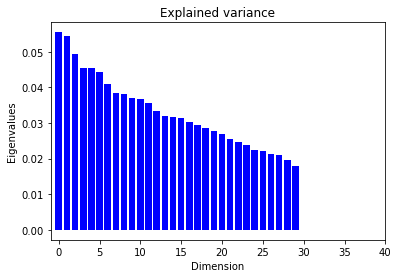

In [176]:
org_data = data_1000D
explained_variance_2 = choose_d(org_data)
plt.figure(figsize=(6, 4))
plt.bar(range(len(explained_variance_2)), explained_variance_2, color='blue')  # You can change the color if desired
plt.xlabel('Dimension')
plt.ylabel('Eigenvalues')
plt.title('Explained variance')
#plt.xticks([])  # Disable x-axis ticks (no specific labels)
#plt.ylim(0, 1)  # Set y-axis limits based on the data range
plt.xlim(-1, 40)
plt.savefig('choice_d.png')
plt.show()

In [177]:
org_data = data_1000D
pca_data1, recon_X1 = pca_buggy(org_data,30)
pca_data2, recon_X2 = pca_demeaned(org_data,30)
pca_data3, recon_X3 = pca_normalized(org_data,30)
pca_data4, recon_X4 = pca_dro(org_data,30)

Reconstruction loss:  (499.74877810325097+0j)
Reconstruction loss:  (0.27304595897860284+0j)
Reconstruction loss:  (0.2736285809976233+0j)
Reconstruction loss:  0.02239215787581586
